In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from sympy import symbols, Eq, Function, Derivative, init_printing

In [ ]:
# Load the data from the CSV file
file_path = 'Microbial_growth_data.csv'
df = pd.read_csv(file_path, sep=';', decimal=',')

In [ ]:
# Convert 'Zeit' to datetime
df['Zeit'] = pd.to_datetime(df['Zeit'], format='%H%M')

# Calculate elapsed time in minutes
df['Elapsed_Time'] = (df['Zeit'] - df['Zeit'].iloc[0]).dt.total_seconds() / 60

# Group by 'Zeit' and calculate mean and standard deviation
grouped = df.groupby('Zeit').agg({
    'OD_IN_RAW': ['mean', 'std'],
    'OD_OUT_RAW': ['mean', 'std'],
    'Elapsed_Time': 'first'
}).reset_index()

# Flatten the multi-level columns
grouped.columns = ['Zeit', 'OD_IN_MEAN', 'OD_IN_STD', 'OD_OUT_MEAN', 'OD_OUT_STD', 'Elapsed_Time']

# Convert the grouped DataFrame to a dictionary
result_dict = grouped.to_dict(orient='records')

In [ ]:
result_dict

[{'Zeit': Timestamp('1900-01-01 09:00:00'),
  'OD_IN_MEAN': 0.25066666666666665,
  'OD_IN_STD': 0.0030550504633039036,
  'OD_OUT_MEAN': 0.38466666666666666,
  'OD_OUT_STD': 0.013012814197295436,
  'Elapsed_Time': 0.0},
 {'Zeit': Timestamp('1900-01-01 09:51:00'),
  'OD_IN_MEAN': 0.3706666666666667,
  'OD_IN_STD': 0.010066445913694336,
  'OD_OUT_MEAN': 0.412,
  'OD_OUT_STD': 0.010583005244258335,
  'Elapsed_Time': 51.0},
 {'Zeit': Timestamp('1900-01-01 10:30:00'),
  'OD_IN_MEAN': 0.594,
  'OD_IN_STD': 0.005291502622129186,
  'OD_OUT_MEAN': 0.6926666666666667,
  'OD_OUT_STD': 0.02411085509336683,
  'Elapsed_Time': 90.0},
 {'Zeit': Timestamp('1900-01-01 11:00:00'),
  'OD_IN_MEAN': 1.1266666666666667,
  'OD_IN_STD': 0.0305505046330389,
  'OD_OUT_MEAN': 1.3333333333333333,
  'OD_OUT_STD': 0.03214550253664321,
  'Elapsed_Time': 120.0},
 {'Zeit': Timestamp('1900-01-01 11:45:00'),
  'OD_IN_MEAN': 2.0866666666666664,
  'OD_IN_STD': 0.05773502691896247,
  'OD_OUT_MEAN': 2.8866666666666667,
  'OD_

In [ ]:
# Print the DataFrame
print("Processed Data:")
print(grouped)


Processed Data:
                  Zeit  OD_IN_MEAN  OD_IN_STD  OD_OUT_MEAN  OD_OUT_STD  \
0  1900-01-01 09:00:00    0.250667   0.003055     0.384667    0.013013   
1  1900-01-01 09:51:00    0.370667   0.010066     0.412000    0.010583   
2  1900-01-01 10:30:00    0.594000   0.005292     0.692667    0.024111   
3  1900-01-01 11:00:00    1.126667   0.030551     1.333333    0.032146   
4  1900-01-01 11:45:00    2.086667   0.057735     2.886667    0.081445   
5  1900-01-01 12:15:00    3.813333   0.080829     4.273333    0.046188   
6  1900-01-01 12:45:00    6.143333   0.124231     6.170000    0.088882   
7  1900-01-01 13:15:00    7.516667   0.104083     8.538333    0.037528   
8  1900-01-01 13:45:00    9.733333   0.166533    11.026667    0.506491   
9  1900-01-01 14:22:00   11.160000   0.211660    12.480000    0.200000   
10 1900-01-01 14:51:00   12.613333   0.061101    14.493333    0.023094   
11 1900-01-01 15:21:00   13.850000   0.312250    16.416667    0.416333   

    Elapsed_Time  
0 

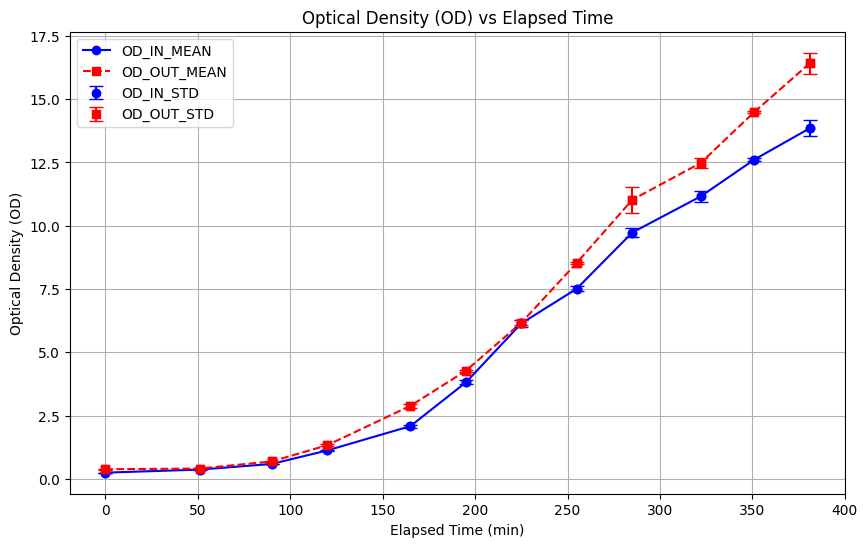

In [ ]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(grouped['Elapsed_Time'], grouped['OD_IN_MEAN'], label='OD_IN_MEAN', marker='o', linestyle='-', color='blue')
plt.plot(grouped['Elapsed_Time'], grouped['OD_OUT_MEAN'], label='OD_OUT_MEAN', marker='s', linestyle='--', color='red')

# Add error bars for standard deviation
plt.errorbar(grouped['Elapsed_Time'], grouped['OD_IN_MEAN'], yerr=grouped['OD_IN_STD'], fmt='o', color='blue', capsize=5, label='OD_IN_STD')
plt.errorbar(grouped['Elapsed_Time'], grouped['OD_OUT_MEAN'], yerr=grouped['OD_OUT_STD'], fmt='s', color='red', capsize=5, label='OD_OUT_STD')

# Add labels and title
plt.xlabel('Elapsed Time (min)')
plt.ylabel('Optical Density (OD)')
plt.title('Optical Density (OD) vs Elapsed Time')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
#Pump RPM 12

In [ ]:
# Extract data
t_exp = np.array([entry['Elapsed_Time'] for entry in result_dict])  # Time points (minutes)
X_CSTR_exp = np.array([entry['OD_IN_MEAN'] for entry in result_dict])  # OD at CSTR outlet (PFR inlet)
X_PFR_out_exp = np.array([entry['OD_OUT_MEAN'] for entry in result_dict])  # OD at PFR outlet (CSTR inlet)

# Convert time to hours (if necessary)
t_exp = t_exp / 60  # Convert minutes to hours

In [ ]:
# Parameters
F = 2.47e-6  # Flow rate (m³/s)
V = 0.0015  # Volume of CSTR (m³)

In [ ]:
# Define the CSTR ODE with logistic growth
def cstr_ode(t, X_CSTR, mu_max, X_max, X_in_interp):
    X_in = np.interp(t, t_exp, X_in_interp)  # Interpolate CSTR inlet concentration
    growth_term = mu_max * X_CSTR * (1 - X_CSTR / X_max)  # Logistic growth term
    return (F / V) * (X_in - X_CSTR) + growth_term

# Define the objective function
def objective(params):
    mu_max, X_max = params
    # Solve the CSTR ODE
    sol = solve_ivp(cstr_ode, (t_exp[0], t_exp[-1]), [X_CSTR_exp[0]], args=(mu_max, X_max, X_PFR_out_exp), t_eval=t_exp)
    X_CSTR_model = sol.y[0]

    # Calculate SSE
    SSE = np.sum((X_CSTR_exp - X_CSTR_model) ** 2)
    return SSE

# Initial guesses for mu_max and X_max
params_initial = [0.5, 20.0]  # Replace with reasonable initial guesses

# Perform optimization
result = minimize(objective, params_initial, method='L-BFGS-B')
mu_max_opt, X_max_opt = result.x

print(f"Optimized mu_max: {mu_max_opt}")
print(f"Optimized X_max: {X_max_opt}")

Optimized mu_max: 0.9440533282750442
Optimized X_max: 15.91049945150417


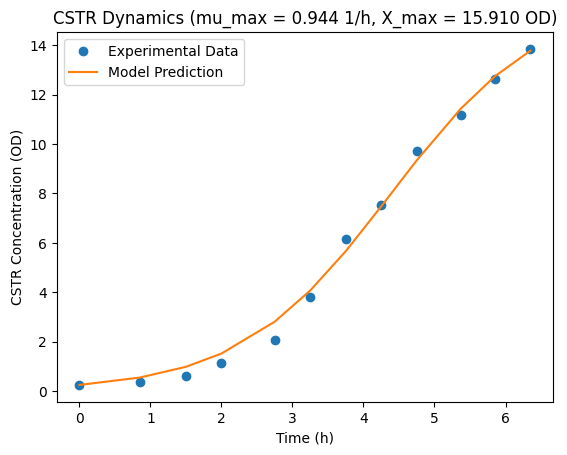

In [ ]:
# Solve the CSTR ODE with the optimized parameters
sol = solve_ivp(cstr_ode, (t_exp[0], t_exp[-1]), [X_CSTR_exp[0]], args=(mu_max_opt, X_max_opt, X_PFR_out_exp), t_eval=t_exp)
X_CSTR_model = sol.y[0]

# Plot the results
plt.plot(t_exp, X_CSTR_exp, 'o', label='Experimental Data')
plt.plot(t_exp, X_CSTR_model, '-', label='Model Prediction')
plt.xlabel('Time (h)')
plt.ylabel('CSTR Concentration (OD)')
plt.legend()
plt.title(f'CSTR Dynamics (mu_max = {mu_max_opt:.3f} 1/h, X_max = {X_max_opt:.3f} OD)')
plt.show()

In [ ]:
# PFR
L = 13         # Reactor length (m)
u = 0.03145        # Superficial velocity (m/s)
D = 0.01         # Axial dispersion coefficient (m²/s)
Nz = 1000         # Number of spatial grid points

mu_max = mu_max_opt     # Maximum specific growth rate (1/h)
X_max = X_max_opt     # Maximum biomass concentration (OD)

z = np.linspace(0, L, Nz)
dz = z[1] - z[0]

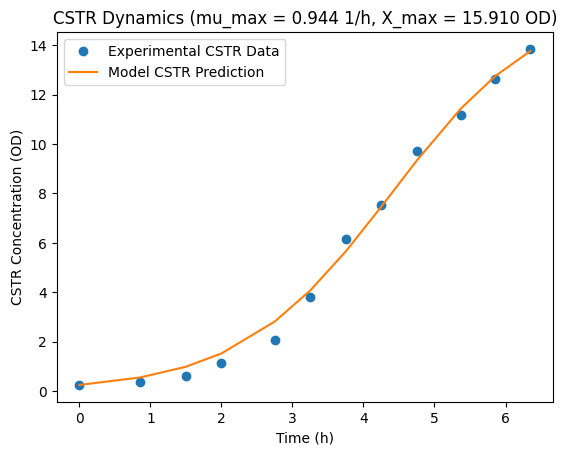

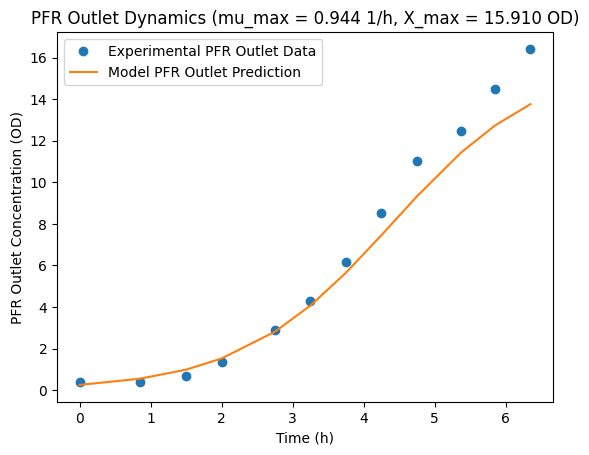

In [ ]:
# Define the CSTR ODE
def cstr_ode(t, X_CSTR, X_PFR_out, mu_max, X_max):
    growth_term = mu_max * X_CSTR * (1 - X_CSTR / X_max)  # Logistic growth term
    return (F / V) * (X_PFR_out - X_CSTR) + growth_term

# Define the PFR model
def pfr_model(t, X, X_CSTR, mu_max, X_max):
    dXdt = np.zeros(Nz)

    # Inlet boundary condition
    dXdt[0] = (u * X_CSTR - u * X[0] + D * (X[1] - X[0])) / dz

    # Interior points
    for i in range(1, Nz-1):
        growth_term = mu_max * X[i] * (1 - X[i] / X_max)  # Logistic growth term
        dXdt[i] = -u * (X[i] - X[i-1]) / dz + D * (X[i+1] - 2*X[i] + X[i-1]) / dz**2 + growth_term

    # Outlet boundary condition
    dXdt[-1] = -u * (X[-1] - X[-2]) / dz + D * (-X[-1] + X[-2]) / dz**2 + mu_max * X[-1] * (1 - X[-1] / X_max)

    return dXdt

# Define the coupled system
def coupled_system(t, y, mu_max, X_max):
    X_CSTR = y[0]          # CSTR concentration
    X = y[1:]              # Biomass concentration in the PFR

    # PFR outlet concentration
    X_PFR_out = X[-1]

    # CSTR dynamics
    dXCSTR_dt_val = cstr_ode(t, X_CSTR, X_PFR_out, mu_max, X_max)

    # PFR dynamics
    dXdt = pfr_model(t, X, X_CSTR, mu_max, X_max)

    # Combine dXCSTR/dt and dXdt
    dydt = np.hstack((dXCSTR_dt_val, dXdt))
    return dydt

# Initial conditions
XCSTR0 = X_CSTR_exp[0]  # Initial CSTR concentration
X0 = np.full(Nz, 0.25)   # Initialize PFR with a small concentration
y0 = np.hstack((XCSTR0, X0))

# Time span
t_span = (t_exp[0], t_exp[-1])  # Simulation time

# Solve the system of ODEs
sol = solve_ivp(coupled_system, t_span, y0, method='BDF', t_eval=t_exp, args=(mu_max, X_max))

# Extract results
X_CSTR_model = sol.y[0, :]  # CSTR concentration over time
X_PFR_model = sol.y[1:, :]  # PFR concentration over time

# Plot the results
plt.figure()
plt.plot(t_exp, X_CSTR_exp, 'o', label='Experimental CSTR Data')
plt.plot(t_exp, X_CSTR_model, '-', label='Model CSTR Prediction')
plt.xlabel('Time (h)')
plt.ylabel('CSTR Concentration (OD)')
plt.legend()
plt.title(f'CSTR Dynamics (mu_max = {mu_max:.3f} 1/h, X_max = {X_max:.3f} OD)')

plt.figure()
plt.plot(t_exp, X_PFR_out_exp, 'o', label='Experimental PFR Outlet Data')
plt.plot(t_exp, X_PFR_model[-1, :], '-', label='Model PFR Outlet Prediction')
plt.xlabel('Time (h)')
plt.ylabel('PFR Outlet Concentration (OD)')
plt.legend()
plt.title(f'PFR Outlet Dynamics (mu_max = {mu_max:.3f} 1/h, X_max = {X_max:.3f} OD)')
plt.show()

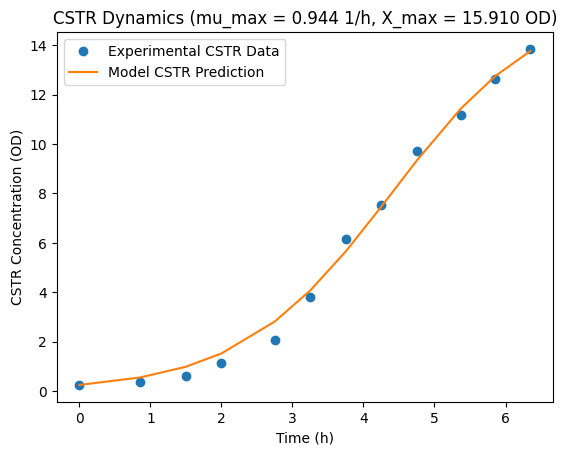

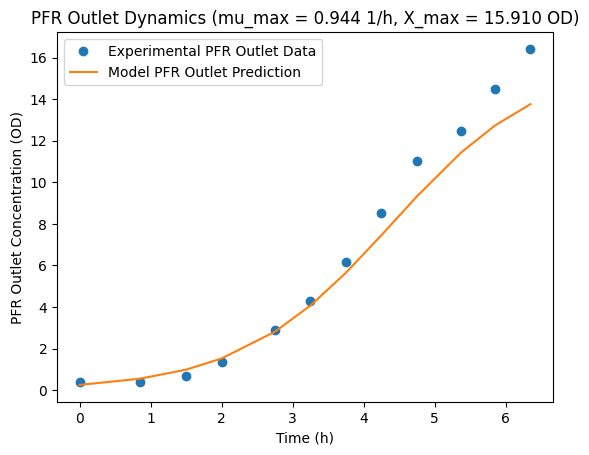

In [ ]:
# Plot the results
plt.figure()
plt.plot(t_exp, X_CSTR_exp, 'o', label='Experimental CSTR Data')
plt.plot(t_exp, X_CSTR_model, '-', label='Model CSTR Prediction')
plt.xlabel('Time (h)')
plt.ylabel('CSTR Concentration (OD)')
plt.legend()
plt.title(f'CSTR Dynamics (mu_max = {mu_max:.3f} 1/h, X_max = {X_max:.3f} OD)')

plt.figure()
plt.plot(t_exp, X_PFR_out_exp, 'o', label='Experimental PFR Outlet Data')
plt.plot(t_exp, X_PFR_model[-1, :], '-', label='Model PFR Outlet Prediction')
plt.xlabel('Time (h)')
plt.ylabel('PFR Outlet Concentration (OD)')
plt.legend()
plt.title(f'PFR Outlet Dynamics (mu_max = {mu_max:.3f} 1/h, X_max = {X_max:.3f} OD)')
plt.show()

In [ ]:
# Define the objective function for parameter estimation
def objective_cstr_pfr(params):
    mu_max, X_max = params

    # Solve the system with the current parameters
    sol = solve_ivp(coupled_system, t_span, y0, method='BDF', t_eval=t_exp, args=(mu_max, X_max))
    X_CSTR_model = sol.y[0, :]
    X_PFR_model = sol.y[1:, :]

    # Calculate the sum of squared errors (SSE)
    SSE_CSTR = np.sum((X_CSTR_exp - X_CSTR_model) ** 2)
    SSE_PFR = np.sum((X_PFR_out_exp - X_PFR_model[-1, :]) ** 2)
    return SSE_CSTR + SSE_PFR


In [ ]:
# Initial guesses for mu_max and X_max
params_initial_cstr_pfr = [mu_max_opt, X_max_opt]  # Replace with reasonable initial guesses